# Morris Lecar model

The Morris Lecar model of an excitable system is a two-dimensional simplification of the Hodgkin-Huxley model of spike generation in squid giant axons.

\begin{equation}
\begin{cases}
\frac{dV}{dt} = \frac{1}{C_M}(\bar{g}_{L}(V-V_L) + \bar{g}_{Ca}M_{\infty}(V)(V-V_{Ca}) + \bar{g}_{K}w\,(V-V_K) + I_\text{app})\\
\frac{dW}{dt} = \phi\,(W_{\infty}(V)-W)\frac{1}{\tau_W(V)} 
\end{cases}\\
\end{equation}
Where:
\begin{equation}
M_{\infty}(V)=0.5*(1+tanh((V-V_1)/V_2))\\
W_{\infty}(V)=0.5*(1+tanh((V-V_3)/V_4))\\
\tau_W(V)=1/(cosh((V-V_3)/(2\cdot V_4)))\\
\end{equation}

Here $I_\text{app}$ is a stimulus current. The constants $\bar{g}_{L},\bar{g}_{Ca}\bar{g}_{K}$ denote the maximum conductances of leak currents, $Ca^{2+}$ and $K^{+}$ and $V_L$, $V_{Ca}$, $V_K$ represent the equilibrium potentials of corresponding ionic currents.

Characteristics of the model:
- The neuron cell is initally at a resting potential value.
- If we experimentally displace the potential a little bit, it returns to the resting value.
- If the perturbation is higher than a treshold value, the potential will shoot up to a very high value. In other words the spike will occur. After the spike the membrane will return to its resting value

## Time simulation

In [443]:
from functools import partial
import numpy as np
import scipy.integrate
import scipy
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

matplotlib.rcParams.update({
    'font.family': 'serif',
})

In [444]:
# Global model variables
v1, v2, v3, v4 = -1.2, 18, 2, 30
gl, gca, gk = 2, 4.4, 8.0
vl, vca, vk = -60, 120, -84
c = 20
phi = 0.04

In [445]:
def minf(v):
    return 0.5*(1+np.tanh((v-v1)/v2))
def winf(v):
    return 0.5*(1+np.tanh((v-v3)/v4))
def tauw(v):
    return 1/(np.cosh((v-v3)/(2*v4)))

def morris_lecar(x, t, I):
    """Time derivative of the Fitzhugh-Nagumo neural model.
    Args:
       x (array size 2): [Membrane potential, Recovery variable]
       t (float): Time (Not used: autonomous system)
       I (float): Constant stimulus current. 
    Return: dx/dt (array size 2)
    """
    return np.array([(gl*(vl-x[0])+gca*minf(x[0])*(vca-x[0])+gk*x[1]*(vk-x[0])+I)/c, 
                     phi*(winf(x[0])-x[1])/tauw(x[0])])

In [446]:
def get_displacement(param, dmax=0.5,time_span=np.linspace(0,200, 1000), number=20):
    # We start from the resting point...
    ic = scipy.integrate.odeint(partial(morris_lecar, **param),
                                                      y0=[0,0],
                                                      t= np.linspace(0,999, 1000))[-1]
    # and do some displacement of the potential. 
    traj = [] 
    for displacement in np.linspace(0,dmax, number):
        traj.append(scipy.integrate.odeint(partial(morris_lecar, **param),
                                                      y0=ic+np.array([displacement,0]),
                                                      t=time_span))
    return traj

In [447]:
Iapp = [{"I": 0},{"I": 160},{"I": 300}]

time_span = np.linspace(0, 200, num=1500)

In [448]:
# Do the numerical integration.
trajectories = {} # We store the trajectories in a dictionnary, it is easier to recover them. 
for i,param in enumerate(Iapp):
    trajectories[i] = get_displacement(param, time_span=time_span, dmax=50,  number=3)

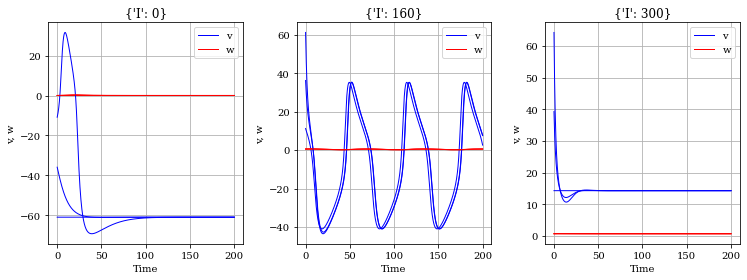

In [449]:
# Draw the trajectories. 
fig, ax = plt.subplots(1, len(Iapp), figsize=(3.5*len(Iapp),4))
for i,param in enumerate(Iapp):
        ax[i].set(xlabel='Time', ylabel='v, w',
                     title='{}'.format(param))
        for j in range(len(trajectories[i])):
            v = ax[i].plot(time_span,trajectories[i][j][:,0], color='b', lw=1)
            w = ax[i].plot(time_span,trajectories[i][j][:,1], color='r', lw=1)
        ax[i].legend([v[0],w[0]],['v','w'])
        ax[i].grid(True)
plt.tight_layout()
plt.savefig('./img/time_run.pdf')

### Isoclines

Isoclines zero (or null-clines) are the manifolds on which one component of the flow is null. 


To find the null-isoclines, you have to solve:

\begin{equation}
\frac{dv}{dt} = 0 \Leftrightarrow w = -\frac{\bar{g}_{L}(V-V_L) + \bar{g}_{Ca}M_{\infty}(V)(V-V_{Ca}) + \bar{g}_{K}w\,(V-V_K) + I_\text{app}}{\bar{g}_{K}\,(V-V_K)}
\end{equation}

For the first one and:

\begin{equation}
\frac{dw}{dt} = 0 \Leftrightarrow w = \phi\,W_{\infty}(V)
\end{equation}

For the second one. 

In [8]:
def plot_isocline(ax, I, color='k', style='--', opacity=.5, vmin=-82,vmax=60):
    """Plot the null iscolines of the morris lecar system"""
    v = np.linspace(vmin,vmax,100)
    
    w1 = -(gl*(vl-v)+gca*minf(v)*(vca-v)+I)/(gk*(vk-v))
    w2 = winf(v)
    
    ax.plot(v, w1, style, color=color, alpha=opacity)
    ax.plot(v, w2, style, color=color, alpha=opacity)
    
    ax.set_ylim(-0.1,1.2)

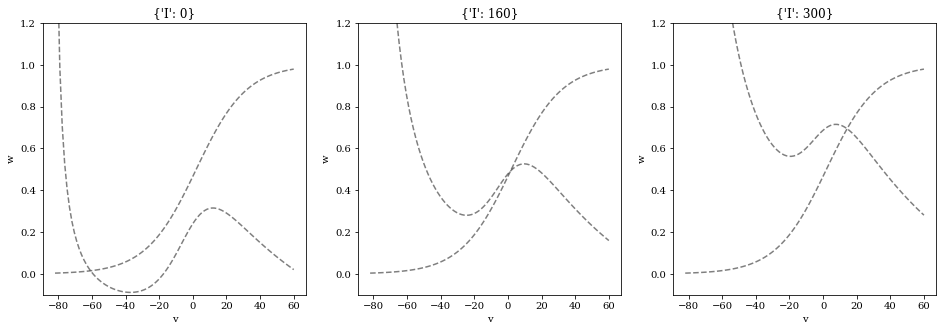

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, sc in enumerate(Iapp):
    plot_isocline(ax[i], **sc)
    ax[i].set(xlabel='v', ylabel='w',
              title='{}'.format(sc))

### Flow

Let us plot the flow, which is the vector field defined by:

$F: \mathbb R^2 \mapsto \mathbb R^2$

$\vec F(v,w) = \begin{bmatrix}\frac{dv}{dt}(v,w)\\  \frac{dw}{dt}(v,w)\end{bmatrix}$



In [10]:
# Plot the flow using matplotlib.pyplot.streamplot. 
# On the domain w \in [-1,1] and v in [-(1+a)/b, (1-a)/b]

In [11]:
def plot_vector_field(ax, param, xrange, yrange, steps=180):
    # Compute the vector field
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    
    dx,dy = morris_lecar([X,Y],0,**param)   
    
    # streamplot looks nicer than quiver
    ax.streamplot(X,Y,dx, dy, color=(0,0,0,.15))
    
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

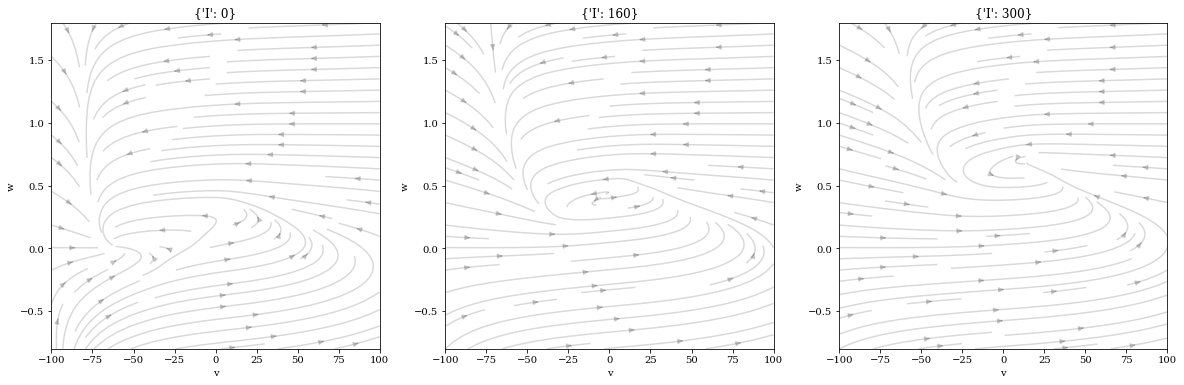

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, sc in enumerate(Iapp):
    xrange = (-100, 100)
    yrange = [-0.8, 1.8]
    plot_vector_field(ax[i], sc, xrange, yrange, 10)
    ax[i].set(xlabel='v', ylabel='w',
          title='{}'.format(sc))

### Equilibrium points and behaviour
The equilibria are found at the crossing between the null-isocline for $v$ and the one for $w$. 

I found the points with AUTO, see the results:

```
i = 0

v=-60.855
w=0.014915
eigenvalues STABLE NODE c- = 2
a = -0.82220 + i*0.015827 
b = -0.82220 - i*0.015827

i = 150

v=-0.45984
w=0.45909
eigenvalues UNSTABLE FOCUS r+ = 2
a = -0.263862 + i*0.00 
b = -0.032843 - i*0.00

i = 300

v=14.302
w=0.69427
eigenvalues STABLE NODE c- = 2
a = -0.136603 + i*0.116418 
b = -0.136603 - i*0.116418
```



In [13]:
eq = {
    0: {"point": [-60.855,0.014915],
        "eq": "Stable node",
        "c": "red"},
    160: {"point": [-0.45984,0.459090],
          "eq": "Unstable focus",
          "c": "orange"},
    300: {"point": [14.302,0.69427],
          "eq": "Stable focus",
          "c": "red"}
}

### Complete phase diagram

In [14]:
def plot_phase_diagram(param, eq, stability, ax=None, title=None):
    
    title = "Phase space, {}".format(param) 
    ax.set(xlabel='v', ylabel='w', title=title)
        
    # Isocline and flow... 
    xlimit = (-100, 100)
    ylimit = (-.3, 1.4)
    plot_vector_field(ax, param, xlimit, ylimit)
    plot_isocline(ax, **param, vmin=-82, vmax=xlimit[1])
    
    # Plot the equilibria 
    p = eq["point"]
        
    for perturb in (0.1, 0.8):
        ic = [p[0]+perturb*abs(p[0]), p[1]]
        traj = scipy.integrate.odeint(partial(morris_lecar, **param),
                                          y0=ic,
                                          t=time_span)
        ax.plot(traj[:,0], traj[:,1], c='b')
    
    ax.scatter(p[0],p[1],c=eq['c'],s=50)


    # Legend
    legend = [Line2D([0], [0],marker="s", markerfacecolor=eq['c'], markersize=10, color='w', lw=4)]
    ax.legend(legend, [eq["eq"]], loc=2, prop={'size': 10})

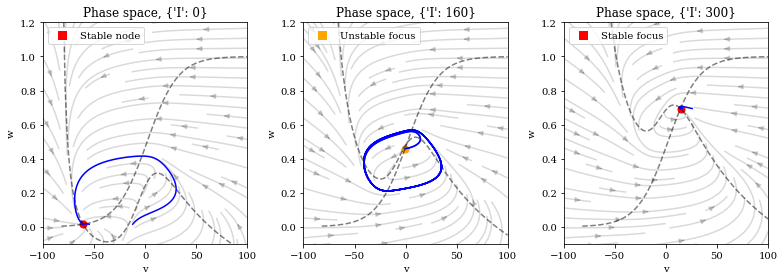

In [450]:
fig, ax = plt.subplots(1,3, figsize=(11, 4))
for i, param in enumerate(Iapp):
    plot_phase_diagram(param, eq[param['I']],"stable", ax[i])
plt.tight_layout()
plt.savefig('./img/phase_dig.pdf')

## Non autonomous system

So far we have considered the behavior of the system under a constant stimulus $I_{ext}$.
However, it is possible to extend this model to cases where the stimulus is more complex, by making $I_{ext}$ a function of time. 

\begin{equation}
\begin{cases}
\frac{dV}{dt} = \frac{1}{C_M}(\bar{g}_{L}(V-V_L) + \bar{g}_{Ca}M_{\infty}(V)(V-V_{Ca}) + \bar{g}_{K}w\,(V-V_K) + I_\text{app}(t))\\
\frac{dW}{dt} = \phi\,(W_{\infty}(V)-W)\frac{1}{\tau_W(V)} 
\end{cases}\\
\end{equation}

Note that now the system is *non-autonomous*.

In [16]:
# Implement a non autonomous version of the Fitzhugh Nagumo Model. 
# Simulate some trajectories. 

# Here are a few stimulus function that you can try. 
def step_stimulus(t, value, time):
    """Step stimulus for the non autonomous Fitzhugh-Nagumo model"""
    return 0 if t<time else value

def step_stimulus_2(t, values, time):
    """Step stimulus for the non autonomous Fitzhugh-Nagumo model"""
    return 0 if t<time else values[int(t//time)] if t<len(values)*time else values[-1]

def periodic_stimulus(t, magnitude, freq):
    """Periodic stimulus for the non autonomous Fitzhugh-Nagumo model"""
    return magnitude * np.sin(freq * t)

def generate_noisy(scale, steps=300, dt=1, tmax=300):
    time = np.linspace(0, tmax, num=steps)
    noise = [0]
    for i in range(len(time)-1):
        noise.append( noise[-1] + (0-noise[-1])*dt + dt*np.random.normal(loc=0, scale=scale))
    def noisy_stimulus(t):
        """Noisy stimulus for the non autonomous Fitzhugh-Nagumo model"""
        tscaled = (t/tmax)*(len(noise)-2)
        i = int(tscaled)
        return (tscaled-i)*noise[i] + (i+1-tscaled)*noise[1+i]
    return noisy_stimulus
    

# Some parameter sets:
step_sc = []
time_span = np.linspace(0, 500, num=1500)

step_sc.append({'I': partial(step_stimulus, value=160, time=100)})   
step_sc.append({'I': partial(step_stimulus_2, values=[0,150,300], time=100)})
step_sc.append({'I': partial(periodic_stimulus, magnitude=180,freq=.1)})
step_sc.append({'I': generate_noisy(500, tmax=time_span[-1], steps=len(time_span))})

initial_conditions = [(-60,0), [0, -0.16]]

In [17]:
def non_autonomous_morris_lecar(x, t, I):
    """Time derivative of the Morris Lecar neural model.
    """
    return np.array([(gl*(vl-x[0])+gca*minf(x[0])*(vca-x[0])+gk*x[1]*(vk-x[0])+I(t))/c, 
                     phi*(winf(x[0])-x[1])/tauw(x[0])])

In [18]:
trajectory_nonauto = {} 
for i, param in enumerate(step_sc):
    flow = partial(non_autonomous_morris_lecar, **param)
    for j, ic in enumerate(initial_conditions):
        trajectory_nonauto[i, j] = scipy.integrate.odeint(flow,
                                                          y0=ic,
                                                          t=time_span)

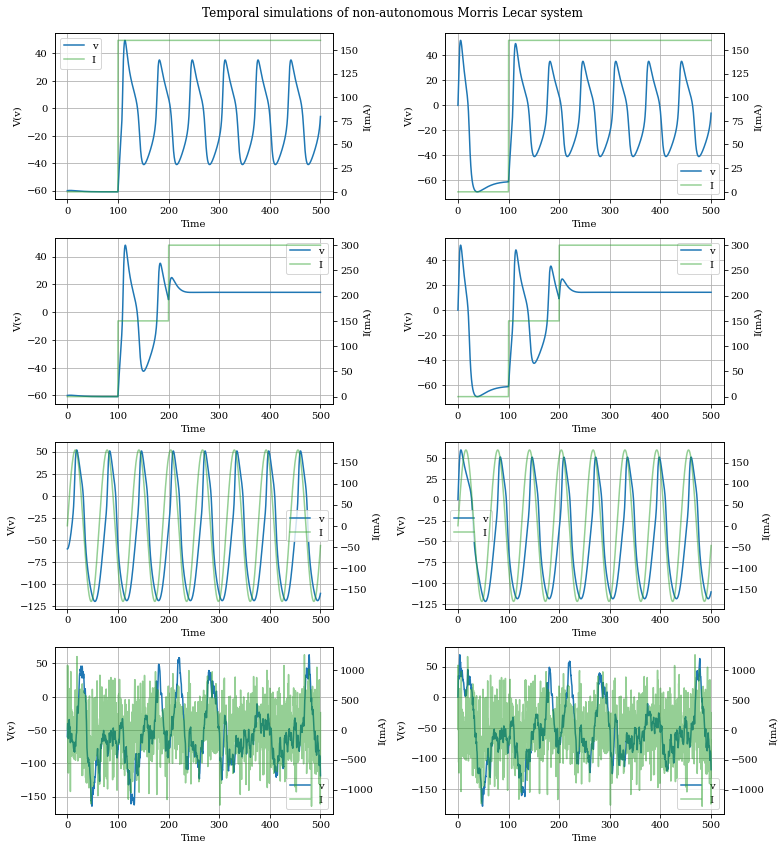

In [19]:
# Draw the trajectories. 
fig, ax = plt.subplots(len(step_sc), 2, figsize=(11,12))
for i, param in enumerate(step_sc):
    for j, ic in enumerate(initial_conditions):
        ax[i, j].set(xlabel='Time', ylabel='V(v)')
        ax[i, j].grid()
        p1, = ax[i, j].plot(time_span,trajectory_nonauto[i, j][:,0], label='v', color='C0', alpha=1)
        # second axis
        ax2 = ax[i,j].twinx()
        p2, = ax2.plot(time_span,[param['I'](t) for t in time_span], label='I', color='C2', alpha=0.5)
        ax2.set(ylabel="I(mA)")
        # set legend
        lines = [p1,p2]
        ax[i,j].legend(lines, [l.get_label() for l in lines])

        #ax[i, j].legend()
fig.suptitle('Temporal simulations of non-autonomous Morris Lecar system')
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('./img/nonautonomous.pdf')

## Stochastic Differential Equation


So far we have seen continuous-time, continuous-state determinsitic systems in the form of Ordinary Differential Equations (ODE). Their stochastic counterpart are Stochastic Differential Equations (SDE).

Consider the now familiar non-autonomous ODE:

\begin{equation}
\frac{dy}{dt} = f(y,t)
\end{equation}

The corresponding integral equation is:

\begin{equation}
y(t) = y(0) + \int_0^t f(y(s),s) ds
\end{equation}

The SDE would be:

\begin{equation}
Y_t = f(Y_t,t) dt + g(Y_t,t) dB_t
\end{equation}

Now $Y_t$ is a random variable. $B_t$ is the standard Brownian motion. 
The corresponding integral equation is:

\begin{equation}
y(t) = y(0) + \int_0^t f(Y_s,s) ds + \int_0^t g(Y_s,s) dB_s
\end{equation}

As indicated will use the [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) integration scheme. 

In [20]:
def euler_maruyama(flow, var, y0, t) :
    ''' Euler-Maruyama intergration.
    
    Args:
        flow (function): deterministic component of the flow (f(Yt,t))
        var (float): stochastic component of the flow (g(Yt,t))
        y0 (np.array): initial condition
        t (np.array): time points to integrate. 
        
    Return the Euler Maruyama approximation of the SDE trajectory defined by:
    
    y(t) = f(Y(t),t)dt + g(Yt,t)dBt
    y(0) = y0 
    '''
    y = np.zeros((len(t),len(y0)))
    y[0] = y0
    for n,dt in enumerate(np.diff(t),1):
        y[n] = y[n-1] + flow(y[n-1],dt)*dt + var*np.random.normal(0,1)*np.sqrt(dt)
    return y

In [21]:
Iapp = [{"I": 0},{"I": 160},{"I": 300}]
scenarios = {}
time_s = np.linspace(0, 1000, num=10000)
var = 0.08
stochastic = {}
trajectory = {}
for i,param in enumerate(Iapp[:2]):
    for j, ic in enumerate(initial_conditions):
        # i is key and j is value in the trajectory dictionary
        flow = partial(morris_lecar, **param)
        stochastic[i, j] = euler_maruyama(flow,
                                          var,
                                          y0=ic,
                                          t=time_s)
        trajectory[i,j] = scipy.integrate.odeint(flow, y0=ic, t=time_s)

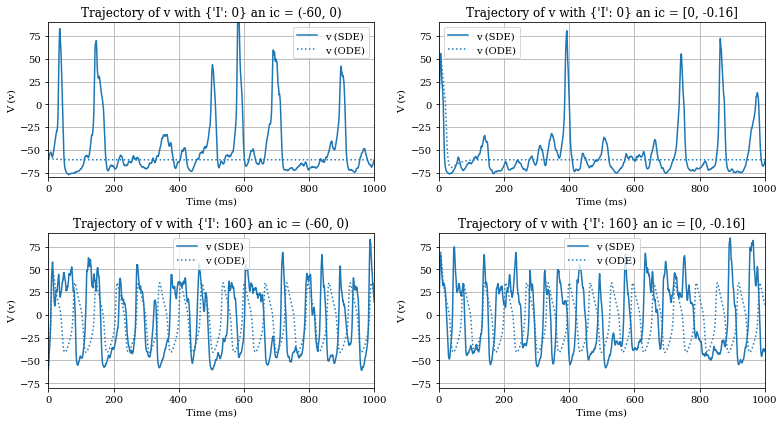

In [22]:
# Draw the trajectories. 
fig, ax = plt.subplots(2, 2, figsize=(11,6))
for i,param in enumerate(Iapp[:2]):
    for j, ic in enumerate(initial_conditions):
        ax[i,j].grid()
        ax[i, j].set(xlabel='Time (ms)', ylabel='V (v)', title='Trajectory of v with {} an ic = {}'.format(param, ic),
                    xlim=(0, time_s[-1]), ylim=(-80, 90))
        ax[i, j].plot(time_s,stochastic[i, j][:,0], label='v (SDE)')
        ax[i, j].plot(time_s,trajectory[i, j][:,0], label='v (ODE)', color='C0', ls=":")
        ax[i, j].legend()
fig.tight_layout()
fig.savefig('./img/sde_time_run.pdf')

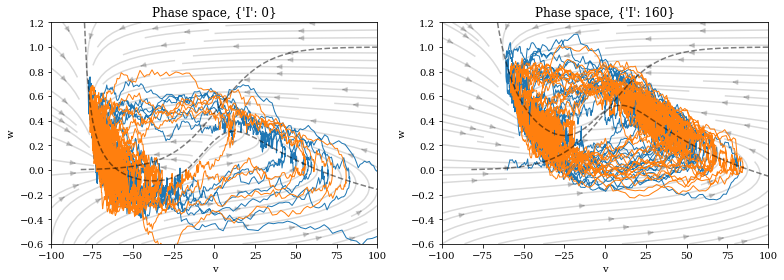

In [23]:
xlimit = (-100, 100)
ylimit = (-0.6, 1.2)
fig, ax = plt.subplots(1,2, figsize=(11,4))
for i, param in enumerate(Iapp[:2]):
    ax[i].set(xlabel='v', ylabel='w', title="Phase space, {}".format(param))
    plot_vector_field(ax[i], param, xlimit, ylimit)
    for j, ic in enumerate(initial_conditions):
        ax[i].plot(stochastic[i, j][:,0], stochastic[i, j][:,1],lw=1)
    plot_isocline(ax[i], **param, vmin=-82, vmax=xlimit[1])    
    ax[i].set(xlim=xlimit,ylim=ylimit)
plt.tight_layout()
fig.savefig('./img/sde_phase.pdf')

**Exercise 6 a**

Take a value of $I_{app}$ in the subtreshold region and obtain 100 realizations of $v(t)$, for $t\in$ [0,100]ms. Compute the average and the standard deviation for every point of the trajectory and plot the result.

In [24]:
time_s = np.linspace(0, 100, num=1001)
var = 0.08
store = {'avg': [],
         'std': []
        }
for _ in range(500):
    # i is key and j is value in the trajectory dictionary
    flow = partial(morris_lecar, I=0)
    stochastic = euler_maruyama(flow,
                                  var,
                                  y0=ic,
                                  t=time_s)
    store['avg'].append(np.average(stochastic[:,0]))
    store['std'].append(np.std(stochastic[:,0]))
    
trajectory = scipy.integrate.odeint(flow, y0=ic, t=time_s)
ode_avg = np.average(trajectory[:,0]) 
ode_std = np.std(trajectory[:,0])

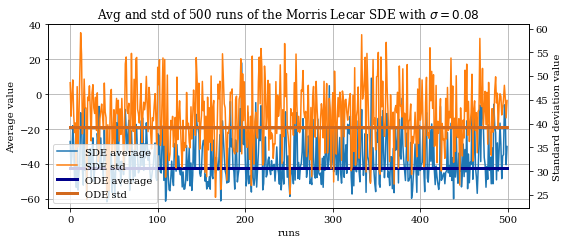

In [452]:
fig, ax = plt.subplots(1,1, figsize=(8,3.5))

# Plot things
p1, = ax.plot(store['avg'],c='tab:blue',alpha=1,label="SDE average")
ax2 = ax.twinx()
p2, = ax2.plot(store['std'],c='tab:orange',alpha=1, label="SDE std")

p3, = ax.plot(np.ones(500)+ode_avg, c='darkblue', lw=3, label="ODE average")
p4, = ax2.plot(np.ones(500)+ode_std, c='chocolate', lw=3, label= "ODE std")

# Set legend
lines = [p1,p2,p3,p4]
ax.set_ylim((-65,40))
ax2.legend(lines, [l.get_label() for l in lines])


# Set grid
ax.grid()

# Set title and axis label
ax.set(title="Avg and std of 500 runs of the Morris Lecar SDE with $\sigma = 0.08$",
       xlabel="runs",
       ylabel="Average value")
ax2.set(ylabel="Standard deviation value")

fig.tight_layout()
fig.savefig('./img/sde_avgstd.pdf')

A histogram is better to visualize the results:

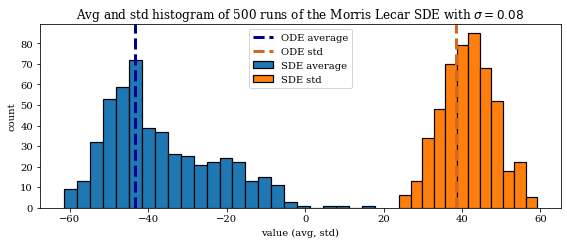

In [451]:
fig, ax = plt.subplots(figsize=(8,3.5))

# Compute hist and plot the data
ax.hist(store['avg'],bins=24, label='SDE average', edgecolor='black', linewidth=1.2)
ax.hist(store['std'],bins=12, label='SDE std', edgecolor='black', linewidth=1.2)

ax.axvline(x=ode_avg, color='darkblue', linestyle='dashed', linewidth=3, label='ODE average')
ax.axvline(x=ode_std, color='chocolate', linestyle='dashed', linewidth=3, label='ODE std')


# Set styling
ax.legend()
ax.set(title="Avg and std histogram of 500 runs of the Morris Lecar SDE with $\sigma = 0.08$",
       xlabel="value (avg, std)",
       ylabel="count")

fig.tight_layout()
fig.savefig('./img/sde_hist_avgstd.pdf')

### Example FFT 

In [27]:
t=np.linspace(0,10, 1001)
sampling_freq = 1000/10
f = 0.5
ana = np.cos(t*(np.pi*2)*f)

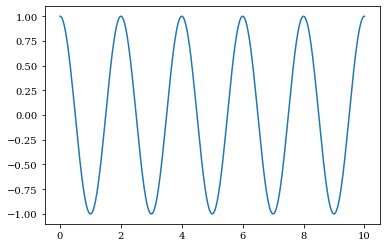

In [28]:
plt.plot(t, ana)

(-2.0, 2.0)

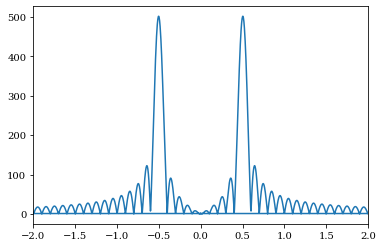

In [29]:
spectrum = np.fft.fft(ana,n=2**15)
freq = np.fft.fftfreq(len(spectrum))*sampling_freq
plt.plot(freq,abs(spectrum))
plt.xlim(-0.02*sampling_freq,0.02*sampling_freq)

In [30]:
solution = freq[np.argmax(abs(spectrum))]
print(f"The frequency with max spectral value is {solution:.2f} Hz")

The frequency with max spectral value is 0.50 Hz


### FFT Plot of a ODE run

In [187]:
time_s = np.linspace(0, 10000, num=20001)
sampling_freq = 20000/10000*1000

flow = partial(morris_lecar, I=150)
trajectory = scipy.integrate.odeint(flow, y0=ic, t=time_s)

In [194]:
spectrum = np.fft.fft(trajectory[:,0],n=2**12)
freq = np.fft.fftfreq(len(spectrum))*sampling_freq

The frequency with max spectral value is 15.1367 Hz


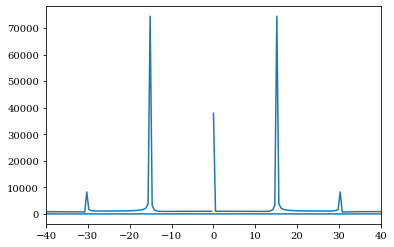

In [195]:
plt.plot(freq, abs(spectrum))
plt.xlim(-0.02*sampling_freq,0.02*sampling_freq)
solution = freq[np.argmax(abs(spectrum))]
print(f"The frequency with max spectral value is {solution:.4f} Hz")

### FFT plot of a SDE run

In [534]:
# Time scales and frequencies
ms, n = 1000, 2001
time_ic = np.linspace(0,ms,n)
sampling_freq = (n-1)/ms*1000
# Paramters
Iapp = 90
var = 0.0

Has 10 peaks


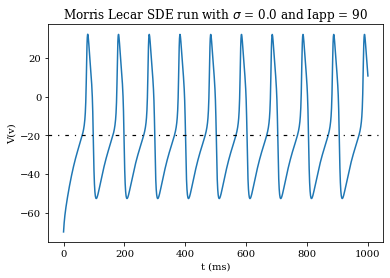

In [535]:
flow = partial(morris_lecar, I=Iapp)
trajectory = euler_maruyama(flow,
                           var,
                           y0=[-70,0.5],
                           t=time_ic)

fig, ax = plt.subplots()
ax.plot(time_ic, trajectory[:,0])
ax.axhline(y=-20, lw=1.2, c="black",linestyle=(0, (3, 5, 1, 5)))

ax.set(title=f"Morris Lecar SDE run with $\sigma$ = {var} and Iapp = {Iapp}",
       xlabel="t (ms)",
       ylabel="V(v)")

The max frequency is 0.1220703125


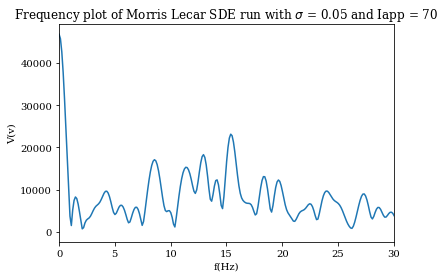

In [437]:
mid = int((2**14)/2)
spectrum = np.fft.fft(trajectory[:,0],n=2**14)[0:mid]
#spectrum[0:5] = 0.0 # Erase the first low frequencies

#freq = np.fft.fftfreq(len(spectrum))[0:mid]*sampling_freq/2
freq = np.arange(0,mid)/2**14*sampling_freq

sorted_freq_index = np.argsort(abs(spectrum))
if 0 == sorted_freq_index[-1]:
    first_max = abs(spectrum[sorted_freq_index[-1]])
    second_max = abs(spectrum[sorted_freq_index[-2]])
    
    if first_max*0.2 > second_max:
        solution = freq[sorted_freq_index[-1]]
    else:
        solution = freq[sorted_freq_index[-2]]
else:
    solution = freq[sorted_freq_index[-1]]

print(f"The max frequency is {solution}")

fig, ax = plt.subplots()
ax.plot(freq, abs(spectrum))
ax.set_xlim(0,0.015*sampling_freq)
ax.set(title=f"Frequency plot of Morris Lecar SDE run with $\sigma$ = {var} and Iapp = {Iapp}",
       xlabel="f(Hz)",
       ylabel="V(v)")

fig.show()

### Getting the frequency with a threshold

In [613]:
def count_peaks(temporal_series, thr):
    # List of values
    values = temporal_series>-thr
    values = values.astype('int')
    # Computes the crossing 1: ascendent -1: descendent
    difference = values[1:]-values[:-1]
    # Count the number of 1 (ascendent crossings)
    peaks = collections.Counter(difference)[1]
    
    return peaks

In [632]:
# Time scales and frequencies
ms, n = 1000, 2001
time_ic = np.linspace(0,ms,n)
sampling_freq = (n-1)/ms*1000
# Paramters
Iapp = 300
var = 0.0

It has 1 peaks and a frequency (peaks/period) of 1.0 Hz


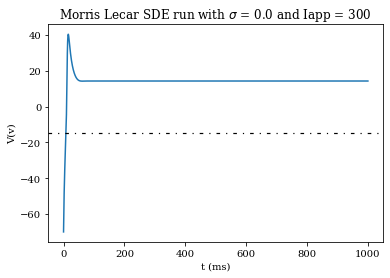

In [633]:
flow = partial(morris_lecar, I=Iapp)
trajectory = euler_maruyama(flow,
                           var,
                           y0=[-70,0.5],
                           t=time_ic)

fig, ax = plt.subplots()
ax.plot(time_ic, trajectory[:,0])
ax.axhline(y=-15, lw=1.2, c="black",linestyle=(0, (3, 5, 1, 5)))

ax.set(title=f"Morris Lecar SDE run with $\sigma$ = {var} and Iapp = {Iapp}",
       xlabel="t (ms)",
       ylabel="V(v)")

peaks = count_peaks(trajectory[:,0],-15)
freq = peaks/ms*1000
print(f"It has {peaks} peaks and a frequency (peaks/period) of {freq} Hz")

### Plotting the f-I curve in terms of $I_{app}$

For the ODE:

In [598]:
# Time scales and frequencies
ms, n = 1000, 2001

time_ic = np.linspace(0,ms,n)
sampling_freq = (n-1)/ms*1000

std = 0.00

Iapps = np.linspace(60,290,50)
solution_ode = np.zeros(Iapps.shape[0])

for i,Iapp in enumerate(Iapps):
    flow = partial(morris_lecar, I=Iapp)
    stochastic = euler_maruyama(flow,
                           std,
                           y0=ic,
                           t=time_s)

    spectrum = np.fft.fft(stochastic[:,0],n=2**12)
    spectrum[0:50] = 0.0 # Erase the first low frequencies

    freq = np.fft.fftfreq(len(spectrum))*sampling_freq
    solution_ode[i] = abs(freq[np.argmax(abs(spectrum))])

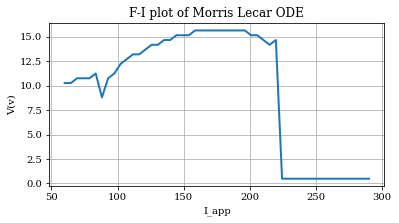

In [599]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(Iapps, solution_ode, lw=2.0)
ax.set(title=f"F-I plot of Morris Lecar ODE",
       xlabel="I_app",
       ylabel="V(v)")
ax.grid()

fig.show()

Using the crossing function

In [638]:
# Time scales and frequencies
ms, n = 10000, 20001
time_ic = np.linspace(0,ms,n)
sampling_freq = (n-1)/ms*1000
# Paramters
Iapp = np.linspace(60,290,50)
var = 0.00

In [639]:
ic = [-70,0.5]

In [640]:
solution_ode = np.zeros(Iapps.shape[0])

for i,Iapp in enumerate(Iapps):
    flow = partial(morris_lecar, I=Iapp)
    stochastic = euler_maruyama(flow,
                           var,
                           y0=ic,
                           t=time_s)

    peaks = count_peaks(stochastic[:,0],-15)
    freq = peaks/ms*1000
    solution_ode[i] = freq

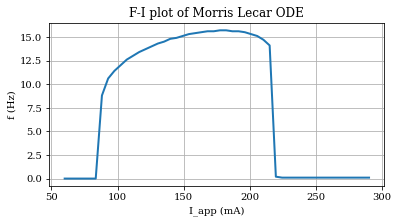

In [641]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(Iapps, solution_ode, lw=2.0)
ax.set(title=f"F-I plot of Morris Lecar ODE",
       xlabel="I_app (mA)",
       ylabel="f (Hz)")
ax.grid()

fig.show()

**Exercise 6 b**

Plot the $f -I$ curve in therms of $I_{app}$ for $\sigma \in \{0.1j\}_{j=1}^{20}$. What do you observe? Explain the differences with respect to $\sigma$.

In [41]:
import os

In [215]:
ms, n = 10000, 20001
time_ic = np.linspace(0,ms,n)
sampling_freq = (n-1)/ms*1000

In [427]:
#stds = np.array([0,0.01,0.05,0.1,0.2])
stds = np.array([0,0.01,0.05])
Iapps = np.linspace(60,250,50)

    
#if (os.path.isfile('./data/fi-curves.npy')):
#    solution = np.load('./data/fi-curves.npy')
#else:
time_ic = np.linspace(0,ms,n)
sampling_freq = (n-1)/ms*1000

n_runs = 10
solution = np.zeros((stds.shape[0],n_runs,Iapps.shape[0]))

for i,var in enumerate(stds):
    if var == 0:
        n_runs = 1
    else:
        n_runs = 10
    print(n_runs)    
    for j in range(n_runs):
        if j%20==0:
            print(f"Sigma={var} - Run {j}/{n_runs}")
        for k, Iapp in enumerate(Iapps):
            flow = partial(morris_lecar, I=Iapp)
            stochastic = euler_maruyama(flow,
                                   var,
                                   y0=ic,
                                   t=time_s)

            spectrum = np.fft.fft(stochastic[:,0],n=2**12)
            spectrum[0:50] = 0.0 # Erase the first low frequencies

            freq = np.fft.fftfreq(len(spectrum))*sampling_freq
            
            sorted_freq_index = np.argsort(abs(spectrum))
            if 0 == sorted_freq_index[-1]:
                first_max = abs(spectrum[sorted_freq_index[-1]])
                second_max = abs(spectrum[sorted_freq_index[-2]])

                if first_max*0.2 > second_max:
                    solution = freq[sorted_freq_index[-1]]
                else:
                    solution = freq[sorted_freq_index[-2]]
            else:
                solution = freq[sorted_freq_index[-1]]
                
            solution[i][j][k] = solution
            
    if var==0:
        solution[i][:][:] = solution[i][0][:]

np.save('./data/fi-curves',solution)

1
Sigma=0.0 - Run 0/1


IndexError: invalid index to scalar variable.

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))

# Plot each result
for i in range(avg_solution.shape[0]):
    ax.plot(Iapps, avg_solution[i,:], lw=2.0, label=f"$\sigma$={stds[i]}")

# Set plot details
ax.set(title=f"F-I plot of Morris Lecar SDE with various $\sigma$",
       xlabel="$I_{app}$ (mA)",
       ylabel="f(Hz)")
ax.grid()
ax.set_ylim(-2,18)
ax.legend(loc=0)

fig.savefig('./img/fi-sde.pdf')

With the threshold counting technique:

In [693]:
# Time scales and frequencies
ms, n = 10000, 20001
time_ic = np.linspace(0,ms,n)
sampling_freq = (n-1)/ms*1000
# Paramters
Iapp = np.linspace(40,260,50)
stds = np.array([0,0.001,0.0025,0.005,0.01,0.02,0.05])
n_runs = 5

In [667]:
solution_ode = np.zeros((stds.shape[0],n_runs,Iapps.shape[0]))

for i, var in enumerate(stds):
    print(f"Now sigma={var}")
    for j in range(n_runs):
        for k, Iapp in enumerate(Iapps):
            flow = partial(morris_lecar, I=Iapp)
            stochastic = euler_maruyama(flow,
                                   var,
                                   y0=ic,
                                   t=time_s)

            peaks = count_peaks(stochastic[:,0],-15)
            freq = peaks/ms*1000
            solution_ode[i][j][k] = freq

Now sigma=0.001
Now sigma=0.0025


In [670]:
avg_solution = np.mean(solution_ode, axis=1) # This averages the results over the n_runs

In [671]:
#avg_solution2 = avg_solution.copy()

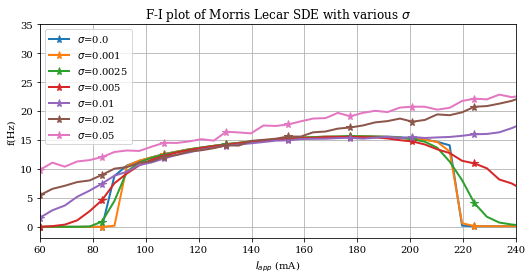

In [717]:
fig, ax = plt.subplots(figsize=(7.5,4))

# Plot each result
for i in range(stds.shape[0]):
    ax.plot(Iapps, avg_solution[i,:], lw=2.0, label=f"$\sigma$={stds[i]}", marker='*', ms=8, markevery=5)

# Set plot details
ax.set(title=f"F-I plot of Morris Lecar SDE with various $\sigma$",
       xlabel="$I_{app}$ (mA)",
       ylabel="f(Hz)")
ax.grid()
ax.set_ylim(-2,35)
ax.set_xlim(60,240)
ax.legend(loc=0)
fig.tight_layout()

fig.savefig('./img/fi-sde.pdf')